<IPython.core.display.Javascript object>


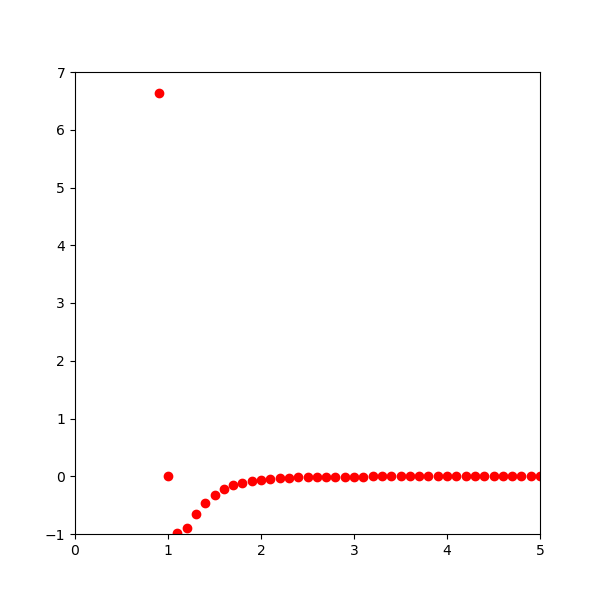

(0.0, 5.0)

In [1]:
# write imports here
import math
import matplotlib.pyplot as plt
#special jupyter notebook command to make plots interactive
%matplotlib notebook

# write calculate_LJ function here
def calculate_LJ(r_ij):
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(1/r_ij, 12)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_ylim([-1,7])
ax.set_xlim([0,5])

In [2]:
# create range 0.1 to 5 in increments of 0.1 to 5
for i in range(1,51):
    r=i * 0.1
    e=calculate_LJ(r)
    ax.plot(r,e,'or')

## Reasoning for Cutoff
3 is a reasonable choice for a cutoff distance as energy of 2 particles at distance 3 is 0.005 and any changes in energy for distances beyond 3 are negligible

In [3]:
import os
config1_file = os.path.join("../../lj_sample_configurations", "lj_sample_config_periodic1.txt")
def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length
sample_coords, box_length = read_xyz(config1_file)

print(box_length)
print(len (sample_coords))



10.0
800


In [4]:
def calculate_distance(coord1, coord2):
    """
    Calculate the distance between two 3D coordinates.
   
    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates
    
    Returns
    -------
    distance: float
        The distance between the two points.
    """
    distance = 0
        
    
    for i in range(3):
        distance += math.pow(coord2[i] - coord1[i], 2)
    
    
    return math.sqrt(distance)

interactions=0
countover3=0

for i in range(0,len(sample_coords)):
    for j in range(0,len(sample_coords)):
        if i<j:
            d_ij=calculate_distance(sample_coords[i],sample_coords[j])
            interactions += 1
            if d_ij>3:
                countover3 += 1
print(interactions)
print(countover3)

countover4=0

for i in range(0,len(sample_coords)):
    for j in range(0,len(sample_coords)):
        if i<j:
            d_ij=calculate_distance(sample_coords[i],sample_coords[j])
            interactions += 1
            if d_ij>4:
                countover4 += 1
print(countover4)

319600
294762
267498


Of 319600 interactions, 294762 interactions are not calculated with a cutoff of $3\sigma$, and 267498 interactions are not calucated with a cutoff of $4\sigma$

In [5]:
## Calculate total energy function here
def calculate_total_energy(coordinates):
    
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_distance(coordinates[i], coordinates[j])
            pairwise_energy = calculate_LJ(dist_ij)
            
            total_energy += pairwise_energy
    
    return total_energy

## Calculate total energy function here accounting for cutoff
def calculate_total_pair_energy(coordinates, cutoff):
    
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_distance(coordinates[i], coordinates[j])
            if dist_ij < cutoff:
                pairwise_energy = calculate_LJ(dist_ij)
            
                total_energy += pairwise_energy
    
    return total_energy

In [6]:
def calculate_tail_correction(box_length, n_particles, cutoff):
    """
    Calculate tail correction
    
    Parameters
    ----------
    box_length: float
        length of box
    
    n_particles: float
        number of particles
        
    cutoff: float
        cutoff distance beyond which interactions are not calculated
        
    Returns
    ---------
    tail_corr: float
        calculated tall correction value
    """
    V=math.pow(box_length,3)
    rc_inv=1/cutoff
    bracket=math.pow(rc_inv,9)*1/3-math.pow(rc_inv,3)
    tail_corr=(8*math.pi*math.pow(n_particles,2)/3/V)*bracket
    return tail_corr

assert round(calculate_tail_correction(box_length,len(sample_coords),3.0),2) == -198.49
assert round(calculate_tail_correction(box_length,len(sample_coords),4.0),3) == -83.769

In [7]:
calculate_total_energy(sample_coords)-calculate_total_pair_energy(sample_coords,3)

-94.78507896918018

There is a difference of 94.79 in energy when considering a cutoff of $3\sigma$

In [9]:
def calculate_periodic_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two points. When `box_length` is set, the minimum image convention is used to calculate the distance between the points.

    Parameters
    ----------
    coord1, coord2 : list
        The coordinates of the points, [x, y, z]
    
    box_length : float, optional
        The box length

    Returns
    -------
    distance : float
        The distance between the two points accounting for periodic boundaries
    """
    distance = 0
        
    for i in range(3):
        hold_dist = abs(coord2[i] - coord1[i])
    
        if box_length != None:    
            if hold_dist > box_length/2:
                hold_dist = hold_dist - (box_length * round(hold_dist/box_length))
        distance += math.pow(hold_dist, 2)

    return math.sqrt(distance)
     
## Calculate total energy function here accounting for cutoff and periodic boundaries
def calculate_new_total_energy(coordinates, cutoff, box_length=None):
    
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            dist_ij = calculate_periodic_distance(coordinates[i], coordinates[j], box_length)
            if dist_ij < cutoff:
                pairwise_energy = calculate_LJ(dist_ij)
            
                total_energy += pairwise_energy
    
    return total_energy

calculate_new_total_energy(sample_coords,3,10)

-4351.540194543858

In [ ]:
def calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates
    
    Returns
    -------
    distance: float
        The distance between the two points.
    """
    
    distance = 0
    for i in range(3):
        dim_dist = (coord1[i] - coord2[i]) 
        
        if box_length:
            dim_dist = dim_dist - box_length * round(dim_dist / box_length)
        
        dim_dist = dim_dist**2
        distance += dim_dist
    
    distance = math.sqrt(distance)
    return distance

In [ ]:
def calculate_tail_correction(box_legth, n_particles, cutoff):
    """
    Calculates the tail correction
    
    Parameters
    ----------
    box_legth : float
        The distance between the particles in reduced units.
    n_particles : int
        The number of particles.
    cutoff : float
        The cutoff value.
    """
    pi_term = (8 * math.pi * math.pow(n_particles, 2)) / (3 * math.pow(box_legth, 3))
    r9_term = (1/3) * (math.pow(1/cutoff, 9))
    r3_term = math.pow(1/cutoff, 3)
    
    tail_correction = pi_term * (r9_term - r3_term)
    
    return tail_correction